# GPU Programminng with `CUDA.jl`

In the previous notebook, we got our first glimpse of the `CUDA.jl` package and
how it allows us to reap the benefits of GPUs using just high level Julia code
that we already know and love.  We also saw through benchmarking how much
speedup this can provide.  In this notebook we are going to recreate the
`intshift` and `intfdr` functions from an earlier notebook and the `fdshift` and
`fftfdr` functions from the previous notebook.  We will do some further
benchmarking to see how `CUDA.jl` accelerates these functions and explore peak
searching algorithms.  Finally we will do a comparison of the GPU performance of
these two techniques, integer sample shifting vs Fourier domain sample shifting,
in terms of generating frequency drift rate matrices.

Before we get into all that, it is worth repeating some of the key benefits that
`CUDA.jl` offers:

- Access to the full CUDA driver API from Julia, including asynchronous
  programming constructs such as events, streams, and graphs

- Access to many other CUDA APIs from Julia including cuBLAS, cuFFT, cuRAND,
  cuSparse, cuSolver, and cuDN.
  
- Ability to write and launch custom CUDA kernels using only Julia thereby
  solving the *two langauge problem*

- Ability to automatically compile and launch efficient kernels for regular
  Julia functions simply by passing a `CuArray` rather than an `Array`

The power of the last point cannot be overemphasized.  Regular Julia functions
that operate on `AbstractArray`s can be passed a `CuArray` (essentially an
`AbstractArray` subtype that is backed by memory on the GPU) and the code will
automatically run parallelized on the GPU asynchronously.  Some restrictions
apply, such as avoiding scalar indexing, but for the most part these are
actually just good Julia coding practices anyway.  Functions being run on
the GPU this way do not have to know anything about CUDA or kernels.  This
allows the exact same code to run on either CPUs or GPUs depending on the type
of `AbstractArray` being operated on (non-`CuArray` or `CuArray`).  This vastly
streamlines the development process by allowing code to be developed and tested
on non-GPU systems and then moved to GPUs without have to rewrite or retest the
core algorithms.  Not only does this solve the two language problem, it also
solves the *two paradigm problem*.

In [1]:
# Perform some preliminary Julia setup
# This may take some time the very first time it runs
using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

using Plots
using CUDA
using FFTW
using HDF5
using Downloads
using LinearAlgebra
using BenchmarkTools
default(legend=false)
# Workaround for CUDA.jl issue https://github.com/JuliaGPU/CUDA.jl/issues/1559
AbstractFFTs.plan_brfft(A::CuArray, d::Integer, region; kwargs...) = plan_brfft(A, d, region)
# Disable scalar indexing to prevent use of inefficient access patterns
CUDA.allowscalar(false)

  Activating project at `~/JuliaDeDopplerNotebooks`


## Read in the data

We're getting good at this...

In [2]:
voyager_url = "http://blpd14.ssl.berkeley.edu/voyager_2020/single_coarse_channel/single_coarse_guppi_59046_80036_DIAG_VOYAGER-1_0011.rawspec.0000.h5"
h5 = h5open(Downloads.download(voyager_url))
full_spectrogram = h5["data"][:,1,:]
freq_range = range(659935, length=150)
spectrogram = full_spectrogram[freq_range,:]
size(spectrogram), size(full_spectrogram)

((150, 16), (1048576, 16))

## Recreate `intshift` and `intfdr`

Recreate the `intshift` and `intfdr` functions.  We have also added a mutating
`intshift!` function and given `intfdr` a 3D "work" array that gives each rate
its own work buffer to make it more amenable to parallelization.  We also
changed `intfdr` to use `sum!` with "views" created using the `@views` macro.

In [3]:
function intshift!(dout, din, rate)
    for (i, (cin, cout)) in enumerate(zip(eachcol(din), eachcol(dout)))
        n = round(rate*(i-1))
        circshift!(cout, cin, n)
    end
    return dout
end

function intshift(din, rate)
    dout = similar(din)
    intshift!(dout, din, rate)
end

function intfdr(spectrogram, rates)
    Nf, Nt = size(spectrogram)
    Nr = length(rates)
    fdr = similar(spectrogram, Nf, Nr)
    # Create 3D work array so that each rate will get its own work Matrix.
    # This makes it possible to parallelize the for loop.
    work = similar(spectrogram, Nf, Nt, Nr)
    for (i,r) in enumerate(rates)
        @views sum!(fdr[:,i], intshift!(work[:,:,i], spectrogram, r))
    end
    return fdr
end

intfdr (generic function with 1 method)

## Recreate the `fdshift` and `fftfdr` functions

The `fdshift` and `fftfdr` functions along with the suppoerting `phasor` methods
are recreated here essentially unchanged from the prevous notebook.

In [4]:
function phasor(k::Integer, n::Integer, r::Float32, N::Integer)
    cispi(-2*k*n*r/N)
end

function phasor(i::CartesianIndex, r, N)
    phasor(i[1]-1, i[2]-1, r, N)
end

function fdshift_workspace(spectrogram::AbstractMatrix{<:Real}; bunaligned=true)
    i, j = size(spectrogram)
    mat = similar(spectrogram, Complex{eltype(spectrogram)}, i÷2+1, j)
    vec = similar(mat, i÷2+1)
    fplan = plan_rfft(spectrogram, 1)
    bplan = plan_brfft(vec, i; flags=FFTW.ESTIMATE|(bunaligned ? FFTW.UNALIGNED : 0))
    (mat=mat, vec=vec, fplan=fplan, bplan=bplan)
end

function fdshift!(dest::AbstractVector, spectrogram::AbstractMatrix, rate, workspace)
    Nf = size(spectrogram, 1)
    @assert length(dest) == Nf "Incorrect destination size"

    # Calculate forward FFT of spectrogram to get into the Fourier domain
    mul!(workspace.mat, workspace.fplan, spectrogram)

    # Multiply the fourier domain spectra by the doppler rate phasors using the
    # function given as `phasorize`.
    workspace.mat .*= phasor.(CartesianIndices(workspace.mat), Float32(rate), Nf)

    # Sum over time in the Fourier domain
    sum!(workspace.vec, workspace.mat)

    # Store the backwards FFT of `workspace.vec` into `dest`.
    mul!(dest, workspace.bplan, workspace.vec)
end

function fftfdr(spectrogram, rates)
    Nf = size(spectrogram, 1)
    Nr = length(rates)
    fdr = similar(spectrogram, Nf, Nr)
    ws = fdshift_workspace(spectrogram)
    for (i,r) in enumerate(rates)
        fdshift!(@view(fdr[:,i]), spectrogram, r, ws)
    end
    return fdr
end;


## Verify that `intfdr` and `fftfdr` work as before

Before we benchmark CPU and GPU performance of these two functions, let's check
that the recreated versions still work.  Not much has changed with `fftfdr`, but
we did make a few significant changes to `intfdr`.

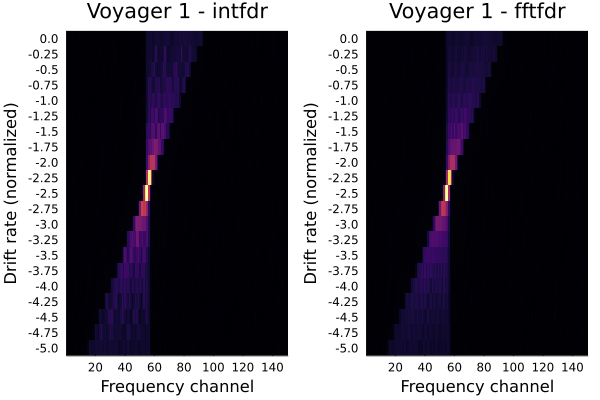

In [5]:
rates = 0:-0.25:-5
Nr = length(rates)
spectrogram_intfdr = intfdr(spectrogram, rates)
spectrogram_fftfdr = fftfdr(spectrogram, rates)
plot(
    heatmap(spectrogram_intfdr',
        title = "Voyager 1 - intfdr",
        xlabel = "Frequency channel",
        ylabel = "Drift rate (normalized)",
        yflip=true, yticks=(1:Nr, rates)
    ),
    heatmap(spectrogram_fftfdr',
        title = "Voyager 1 - fftfdr",
        xlabel = "Frequency channel",
        ylabel = "Drift rate (normalized)",
        yflip=true, yticks=(1:Nr, rates)
    ),
    layout=(1,2)
)

Yay, they look the same as before!  Now we can move on to benchmarking.

## Benchmarking

### CPU

#### Small spectrogram

In [6]:
@benchmark intfdr($spectrogram, $rates)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  26.060 μs …   2.716 ms  ┊ GC (min … max):  0.00% … 96.11%
 Time  (median):     27.780 μs               ┊ GC (median):     0.00%
 Time  (mean ± σ):   33.582 μs ± 115.445 μs  ┊ GC (mean ± σ):  14.78% ±  4.25%

  ▃▇█▇▆▃▂▁                                                     ▂
  █████████▇▆▁▁▁▃▁▁▁▁▅▆▅▃▅▄▆▆▅▄▄▃▄▁▁▁▁▁▁▁▁▁▁▃▃▁▃▃▄▄▅▅▄▅▄▁▃▁▄▇▇ █
  26.1 μs       Histogram: log(frequency) by time      62.3 μs <

 Memory estimate: 209.38 KiB, allocs estimate: 3.

In [7]:
@benchmark fftfdr($spectrogram, $rates)

BenchmarkTools.Trial: 8226 samples with 1 evaluation.
 Range (min … max):  584.256 μs …  26.141 ms  ┊ GC (min … max): 0.00% … 47.52%
 Time  (median):     599.331 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   605.449 μs ± 356.495 μs  ┊ GC (mean ± σ):  0.38% ±  0.64%

                        ▃▃▃▆▆▅▅▅▆▆▇█▇▇▆▅▃▂▂▁                     
  ▂▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▅▆▆████████████████████████▆▆▅▅▅▄▅▄▄▄▃▃▃▃▃▂ ▅
  584 μs           Histogram: frequency by time          612 μs <

 Memory estimate: 26.72 KiB, allocs estimate: 63.

#### Full spectrogram

In [8]:
@benchmark intfdr($full_spectrogram, $rates)

BenchmarkTools.Trial: 10 samples with 1 evaluation.
 Range (min … max):  441.248 ms … 675.963 ms  ┊ GC (min … max):  0.17% … 34.88%
 Time  (median):     478.070 ms               ┊ GC (median):     8.13%
 Time  (mean ± σ):   512.689 ms ±  79.891 ms  ┊ GC (mean ± σ):  14.49% ± 11.42%

           █                                                     
  ▅▁▁▁▁▁▁▁▅█▁▁▁▁▁▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▁▁▁▁▁▁▅ ▁
  441 ms           Histogram: frequency by time          676 ms <

 Memory estimate: 1.39 GiB, allocs estimate: 4.

In [9]:
@benchmark fftfdr($full_spectrogram, $rates)

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 10.679 s (0.01% GC) to evaluate,
 with a memory estimate of 152.00 MiB, over 67 allocations.

### GPU

In [10]:
# Create CuArrays
cu_spectrogram = CuArray(spectrogram)
cu_full_spectrogram = CuArray(full_spectrogram)
size(cu_spectrogram), size(cu_full_spectrogram)

((150, 16), (1048576, 16))

#### Small spectrogram

In [11]:
@benchmark CUDA.@sync intfdr($cu_spectrogram, $rates)

BenchmarkTools.Trial: 1625 samples with 1 evaluation.
 Range (min … max):  2.843 ms … 210.740 ms  ┊ GC (min … max): 0.00% … 67.00%
 Time  (median):     2.946 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   3.074 ms ±   5.155 ms  ┊ GC (mean ± σ):  2.83% ±  1.66%

                             ▂▁▁▃▁▂▁▂▁▁▄▅▇█▇▇▄▂▆▂▃▁▄▄▃▃        
  ▂▁▁▁▂▂▁▁▁▁▁▁▁▁▂▁▁▂▃▃▃▃▃▅▆▆▇██████████████████████████▇▇▄▄▄▃ ▅
  2.84 ms         Histogram: frequency by time        2.99 ms <

 Memory estimate: 88.72 KiB, allocs estimate: 2725.

In [12]:
@benchmark CUDA.@sync fftfdr($cu_spectrogram, $rates)

BenchmarkTools.Trial: 5281 samples with 1 evaluation.
 Range (min … max):  835.235 μs … 80.299 ms  ┊ GC (min … max): 0.00% … 52.06%
 Time  (median):     854.924 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   943.003 μs ±  2.269 ms  ┊ GC (mean ± σ):  3.31% ±  1.44%

    █▃▁                                                         
  ▃▇███▇▅▄▃▂▂▂▂▁▁▂▂▁▁▂▂▂▂▂▂▁▂▁▁▂▂▁▂▂▂▂▂▂▂▂▂▁▁▁▂▁▂▂▁▁▁▁▁▁▁▂▂▂▂▂ ▂
  835 μs          Histogram: frequency by time         1.18 ms <

 Memory estimate: 92.34 KiB, allocs estimate: 1728.

#### Full spectrogram

In [13]:
@benchmark CUDA.@sync intfdr($cu_full_spectrogram, $rates)

BenchmarkTools.Trial: 517 samples with 1 evaluation.
 Range (min … max):  8.698 ms … 38.755 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     8.794 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   9.678 ms ±  3.329 ms  ┊ GC (mean ± σ):  3.35% ± 6.57%

  █                                                           
  █▅▄▁▄▄▅▁▅▁▄▁▁▁▄▅▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆█▇▅▄▄▁▄▁▁▄▁▁▁▄ ▆
  8.7 ms       Histogram: log(frequency) by time     21.6 ms <

 Memory estimate: 86.50 KiB, allocs estimate: 2713.

In [14]:
@benchmark CUDA.@sync fftfdr($cu_full_spectrogram, $rates)

BenchmarkTools.Trial: 227 samples with 1 evaluation.
 Range (min … max):  21.142 ms … 49.681 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     21.648 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   22.023 ms ±  2.680 ms  ┊ GC (mean ± σ):  0.33% ± 1.97%

   █▁                                                          
  ▆██▁▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▄ ▅
  21.1 ms      Histogram: log(frequency) by time      39.1 ms <

 Memory estimate: 90.20 KiB, allocs estimate: 1721.

In [15]:
# Run this cell to reclaim GPU memory from CUDA.jl's memory pool.  It's a bit of
# a funny name, because it feels more like we are releasing memory rather than
# reclaiming it, but I suppose it's all a matter of perspective.
CUDA.reclaim()